#  <center><b>Μέρος 1: Ανίχνευση Ακμών σε Γκρίζες Εικόνες
##  <b>1.1. Δημιουργία Εικόνων Εισόδου <b/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## <b> 1.1.

In [2]:
img = cv2.imread('edgetest_10.png',cv2.IMREAD_GRAYSCALE)  
print("Resolution: ", img.shape)
print("Range: %d - %d " % (img.min(), img.max()))
I0 = img.astype(np.float)/255

Resolution:  (512, 512)
Range: 0 - 255 


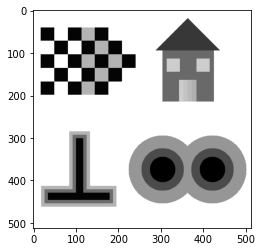

In [3]:
shape = I0.shape
plt.imshow(I0, cmap='gray')
plt.show()

## <b> 1.1.2<b/>
## <b> i) PSNR=20 dB<b/>

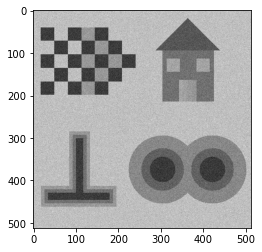

In [4]:
Imax = np.amax(I0)
Imin = np.amin(I0)
sigma = (Imax - Imin)/10
gauss = np.random.normal(0,sigma,shape).reshape(shape)
I = I0 + gauss
plt.imshow(I, cmap='gray')
plt.show()

## <b> ii) PSNR=10 dB<b/>

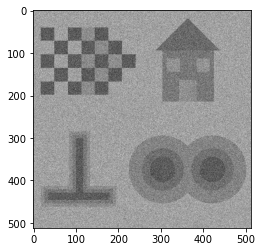

In [5]:
sigma2 = (Imax - Imin)/np.sqrt(10)
gauss2 = np.random.normal(0,sigma2,(shape)).reshape(shape)
I2 = I0 + gauss2
plt.imshow(I2,cmap='gray')
plt.show()

## <b> 1.2 Υλοποίηση Αλγορίθμων Ανίχνευσης Ακμών <b/>

## <b> 1.2.1  Δημιουργία των κρουστικών αποκρίσεων δύο διακριτών γραμμικών φίλτρων<b/>

In [6]:
def creatFilters(image,sigma):
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    gauss2D = gaussian @ gaussian.T
    LoG = cv2.Laplacian(gauss2D, cv2.CV_64F) 
    return [LoG,gauss2D] #επιστρεφει τις αποκρισεις των 2 φιλτρων

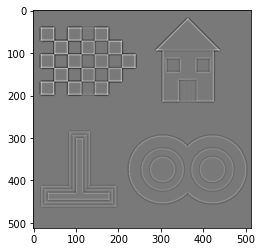

In [7]:
sigma = 1.5
n = int(np.ceil(3*sigma)*2+1)
lin = np.linspace(-round(n/2),round(n/2),n)
            
xx, yy = np.meshgrid(lin,lin)
LoG = (xx**2 + yy**2 -2*sigma**2)*np.exp(-(xx**2 + yy**2)/(2*sigma**2))/(2*np.pi*sigma**6)
I_LoG = cv2.filter2D(I0, -1, LoG) 
plt.imshow(I_LoG,cmap='gray')
plt.show()

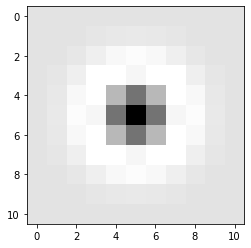

In [8]:
plt.imshow(LoG,cmap='gray')

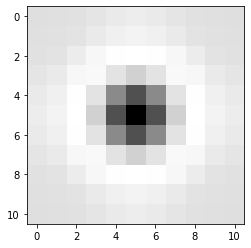

In [9]:
sigma=1.5
n = int(np.ceil(3*sigma)*2+1)
gaussian = cv2.getGaussianKernel(n,sigma) 
gauss2D = gaussian @ gaussian.T
LoG = cv2.Laplacian(gauss2D, cv2.CV_64F) 
plt.imshow(LoG,cmap='gray')

## <center> <b> 1.2.2:  Προσέγγιση της Laplacian <b/>

## <b> i) Γραμμική εκτίμηση της Laplacian: Συνέλιξη της I με την LoG h<b/>

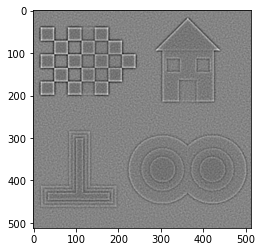

In [10]:
flt = creatFilters(I,1.5)
img_LoG = cv2.filter2D(I, -1, flt[0]) #flt[0] = LoG
plt.imshow(img_LoG,cmap='gray')
plt.show()

## <b> ii)  Μη-γραμμική εκτίμηση της Laplacian της I σ με μορφολογικά φίλτρα <b/>

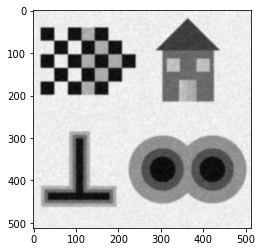

In [11]:
flt = creatFilters(I,1.5)
img_Gauss = cv2.filter2D(I, -1, flt[1]) #flt[1] = Gauss2D
plt.imshow(img_Gauss,cmap='gray')
plt.show()

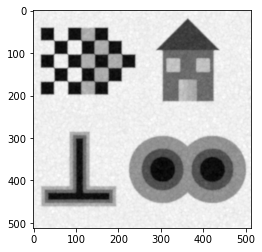

In [12]:
kernel_B = np.array([ 
    [0,1,0],
    [1,1,1],
    [0,1,0]
], dtype=np.uint8)

dilated_img_Gauss = cv2.dilate(img_Gauss, kernel_B)
plt.imshow(dilated_img_Gauss, cmap='gray')
plt.show()

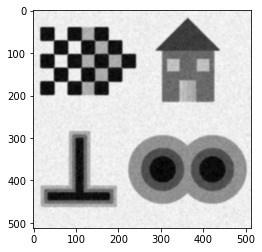

In [13]:
# Erosion
eroded_img_Gauss = cv2.erode(img_Gauss, kernel_B)
plt.imshow(eroded_img_Gauss, cmap='gray')
plt.show()

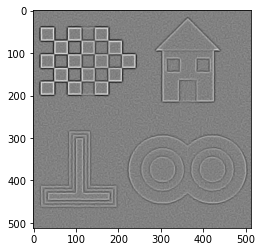

In [14]:
L2 = dilated_img_Gauss + eroded_img_Gauss - 2*img_Gauss
plt.imshow(L2, cmap='gray')
plt.show()

## <b> 1.2.3:  Προσέγγιση των zerocrossings<b/>

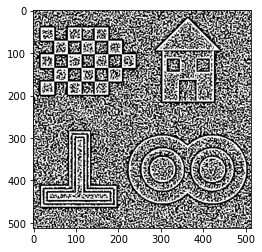

In [15]:
X = np.zeros_like(L2)
X = (L2>=0).astype(np.uint8)
#_, X = cv2.threshold(L2, 0, 1, cv2.THRESH_BINARY)  does the same thing with the above
plt.imshow(X, cmap='gray')
plt.show()

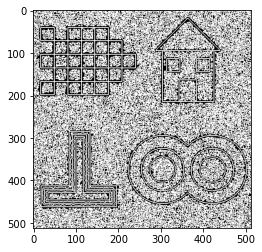

In [16]:
Y = cv2.dilate(X, kernel_B) - cv2.erode(X, kernel_B)

plt.imshow(Y,  cmap='gray')
plt.show()

## <b> 1.2.4:  Aπόρριψη των zerocrossings <b/>

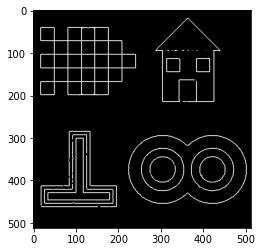

In [17]:
grad = np.sqrt(np.gradient(img_Gauss)[0]**2 + np.gradient(img_Gauss)[1]**2)
temp = np.zeros_like(grad)
theta = 0.2
temp = (grad > theta*np.amax(grad)).astype(np.uint8)
Y2 = Y*temp
plt.imshow(Y2,cmap='gray')
plt.show()

## EdgeDetect Function

In [18]:
def EdgeDetect(I,sigma,theta,LaplType = 0): # 0 για γραμμικη προσέγγιση της Laplacian, 1 για Mη-Γραμμικη
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    gauss2D = gaussian @ gaussian.T
    img_Gauss = cv2.filter2D(I, -1, gauss2D)
    kernel_B = np.array([ #pairnw kernel apo ta 3 pou xrhsimopoioiuntai synh8ws
        [0,1,0],
        [1,1,1],
        [0,1,0]
        ], dtype=np.uint8)
    
    if LaplType == 0:
        lin = np.linspace(-round(n/2),round(n/2),n)    
        xx, yy = np.meshgrid(lin,lin)
        LoG = (xx**2 + yy**2 -2*sigma**2)*np.exp(-(xx**2 + yy**2)/(2*sigma**2))/(2*np.pi*sigma**6)
        
        L = cv2.filter2D(I, -1, LoG)
        # laplacian = cv2.Laplacian(gauss2D, cv2.CV_64F)
        # L = cv2.filter2D(I, -1, laplacian)
    else :
        dilated_img_Gauss = cv2.dilate(img_Gauss, kernel_B)
        eroded_img_Gauss = cv2.erode(img_Gauss, kernel_B)
        L = dilated_img_Gauss + eroded_img_Gauss - 2*img_Gauss
    
    X = np.zeros_like(L)
    X = (L>=0).astype(np.uint8)
    #_, X = cv2.threshold(L, 0, 1, cv2.THRESH_BINARY)
    Y = cv2.dilate(X, kernel_B) - cv2.erode(X, kernel_B)
    grad = np.sqrt(np.gradient(img_Gauss)[0]**2 + np.gradient(img_Gauss)[1]**2)
    temp = np.zeros_like(grad)
    temp = (grad > theta*np.amax(grad)).astype(np.uint8)
    #grad_norm = np.sqrt(np.gradient(I_smooth)[0] ** 2 + np.gradient(I_smooth)[1] ** 2)
    #temp = (grad_norm > theta * grad_norm.max())
    Y2 = Y&temp
    
    return Y2

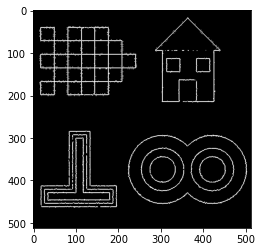

In [19]:
D = EdgeDetect(I,1.5,0.2,0)
plt.imshow(D,cmap='gray')
plt.show()

##  <center><b>1.3. Αξιολόγηση των Αποτελεσμάτων Ανίχνευσης Ακμών <b/>

## <b> 1.3.1

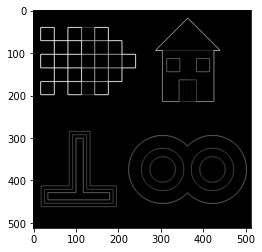

In [20]:
M = cv2.dilate(I0, kernel_B) - cv2.erode(I0, kernel_B)
plt.imshow(M,cmap='gray')
plt.show()

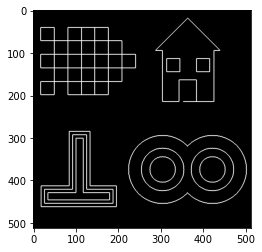

In [21]:
theta2=0.2
T = (M>theta2).astype(np.uint8)
#_, T = cv2.threshold(M, newtheta, 1, cv2.THRESH_BINARY)
plt.imshow(T,cmap='gray')
plt.show()

## <b> 1.3.2

In [22]:
def calcPrecision(T,D):
    cardDT = np.sum(T*D)
    PrTD = cardDT/np.sum(T)
    PrDT = cardDT/np.sum(D)
    C = (PrTD+PrDT)/2
    return C
calcPrecision(T,D)

0.9158619514031326

## <b> 1.3.3
Έχουμε PSNR=20 στην εικόνα I, και PSNR=10 στην I2: <br>
EdgeDetect(I,sigma,theta,LaplType = 0)<br>
    Στην περίπτωση που χρησιμοποιώ μη γραμμική εκτίμηση της LoG, έχουμε μικρή βελτίωση της ακρίβειας

## PSNR = 20db

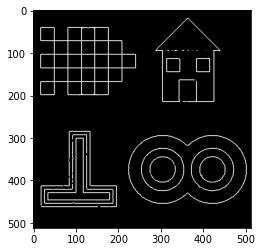

0.9689563039921665

In [23]:
plt1 = EdgeDetect(I,1.5,0.2,1)
plt.imshow(plt1,cmap='gray')
plt.show()
calcPrecision(T,plt1)

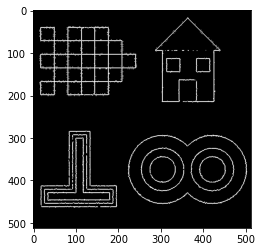

0.9158619514031326

In [24]:
plt2 = EdgeDetect(I,1.5,0.2,0)
plt.imshow(plt2,cmap='gray')
plt.show()
calcPrecision(T,plt2)

## PSNR = 10db

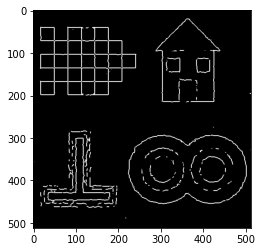

0.7686334765240768

In [25]:
temp1 = EdgeDetect(I2,2.5,0.25,1)
plt.imshow(temp1,cmap='gray')
plt.show()
calcPrecision(T,temp1)

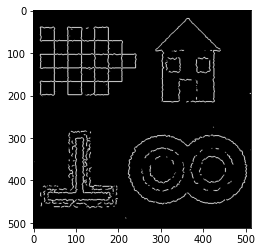

0.688834386909527

In [26]:
temp2 = EdgeDetect(I2,2.5,0.25,0)
plt.imshow(temp2,cmap='gray')
plt.show()
calcPrecision(T,temp2)

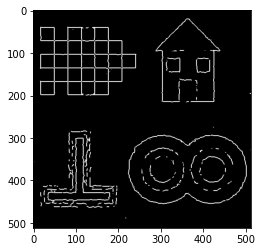

0.7686334765240768

In [27]:
plt3 = EdgeDetect(I2,2.5,0.25,1)
plt.imshow(plt3,cmap='gray')
plt.show()
calcPrecision(T,plt3)

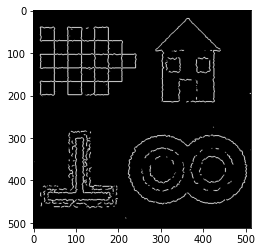

0.688834386909527

In [28]:
plt4 = EdgeDetect(I2,2.5,0.25,0)
plt.imshow(plt4,cmap='gray')
plt.show()
calcPrecision(T,plt4)

##  <center><b>1.4. Εφαρμογή των Αλγορίθμων Ανίχνευσης Ακμών σε Πραγματικές εικόνες <b/>

In [29]:
img1 = cv2.imread('mars.png',cv2.IMREAD_GRAYSCALE)  
img2 = cv2.imread('urban_edges.jpg',cv2.IMREAD_GRAYSCALE)  
img3 = cv2.imread('blood_smear.jpg',cv2.IMREAD_GRAYSCALE)  
print("Resolution: ", img2.shape)
print("Range: %d - %d " % (img2.min(), img2.max()))
Img1 = img1.astype(np.float)/255
Img2 = img2.astype(np.float)/255
Img3 = img3.astype(np.float)/255

Resolution:  (612, 612)
Range: 0 - 255 


In [30]:
Edges1 = EdgeDetect(Img1,2.5,0.25,0)
Edges2 = EdgeDetect(Img2,2.5,0.25,0)
Edges3 = EdgeDetect(Img3,2.5,0.25,0)

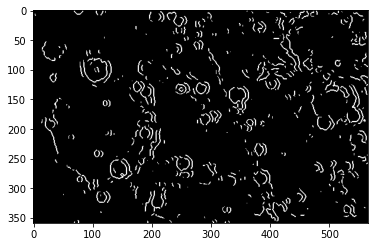

In [31]:
plt.imshow(Edges1,cmap='gray')
plt.show()

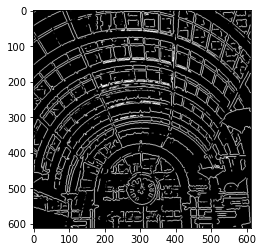

In [32]:
plt.imshow(Edges2,cmap='gray')
plt.show()

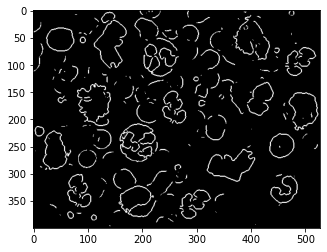

In [33]:
plt.imshow(Edges3,cmap='gray')
plt.show()

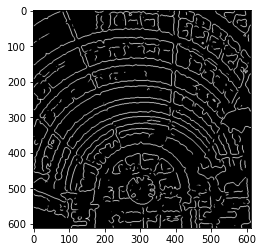

In [34]:
NewNewNewEdges = EdgeDetect(Img2,5,0.25,0)
plt.imshow(NewNewNewEdges,cmap='gray')
plt.show()

#  <center><b>Μέρος 2: Ανίχνευση Σημείων Ενδιαφέροντος (Interest Point Detection) <b/>

In [7]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [4]:
def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(circ)

    return ax

In [5]:
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

##  <center><b>2.1 Ανίχνευση Γωνιών <b/>

In [2]:
def corner_detection(Img_BGR, img_Grey, sigma, p, theta_corn, k):
    Image = img_Grey.astype(np.float)/255
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    Gs = gaussian @ gaussian.T
    Is = cv2.filter2D(Image, -1, Gs)
    
    ############################
    
    n = int(np.ceil(3*p)*2+1)
    gaussian = cv2.getGaussianKernel(n,p) 
    Gp = gaussian @ gaussian.T
    
    ############################
    
    [Ix,Iy]=np.gradient(Is)
    J1 = cv2.filter2D(Ix*Ix, -1, Gp)
    J2 = cv2.filter2D(Ix*Iy, -1, Gp)
    J3 = cv2.filter2D(Iy*Iy, -1, Gp)
    
    ############################
    
    lplus=(J1+J3+np.sqrt((J1-J3)**2+4*J2**2))/2
    lminus=(J1+J3-np.sqrt((J1-J3)**2+4*J2**2))/2
    
    ############################
    #R = np.matmul(lminus, lplus)-k*(lminus+lplus)**2
    #R = l_minus@l_plus - k * (l_minus + l_plus)**2
    R = lminus * lplus - k*(lminus + lplus)**2
    ns = np.ceil(3*sigma)*2+1                             
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    Cond2 = (R > theta_corn*np.amax(R))
    corners = (Cond1*Cond2).astype(np.uint8) # or &
    
    coords = np.nonzero(corners == 1)                  #find the coords of all elements==1
    kp_data = []
    for i in range(np.sum(corners)):
        kp_data.append([coords[1][i],coords[0][i],2])  #store them the way interest_points_visualization wants them
        
    img = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
    temp = interest_points_visualization(img, kp_data)  #call only if you want to show points on image
    return corners

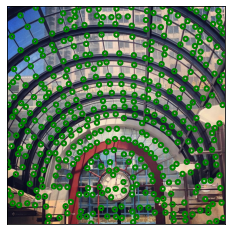

In [8]:
ImgBGR = cv2.imread('urban_edges.jpg')
ImgGrey = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
temp = corner_detection(ImgBGR,ImgGrey,2,2,0.005,0.05)

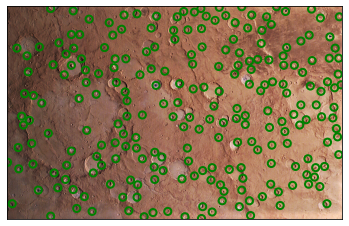

In [9]:
ImgBGR = cv2.imread('mars.png')
ImgGrey = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
temp = corner_detection(ImgBGR,ImgGrey,1.5,2,0.005,0.05)

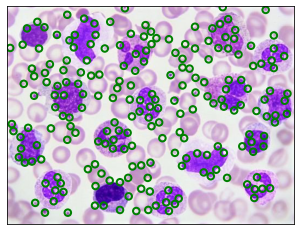

In [10]:
ImgBGR = cv2.imread('blood_smear.jpg')
ImgGrey = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
temp = corner_detection(ImgBGR,ImgGrey,1.5,2,0.005,0.05)

## <center><b>2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών <b/>  <center/>

In [42]:
def Harris_Laplacian(Img_BGR,img_Grey,N,s0,p0,s,theta_corn,k):
    sigma = []
    rho = []
    L = []
    coords = [] 
    kp_data2 = []
    I = img_Grey.astype(np.float)/255
    corners = []
    #######################################################################################
    ###############################  Calculate all σ and ρ  ###############################
    ############ and run for each one the function from 2.1 "corner_detection" ############
    #######################################################################################
    
    for i in range(N):
        sigma.append(s**i*s0)                   
        rho.append(s**i*p0)
        corners.append(corner_detection(Img_BGR,img_Grey,sigma[i],rho[i],theta_corn,k))
        
    #######################################################################################
    ###################################  Calculate LoG  ###################################
    #######################################################################################
    
        n = int(np.ceil(3*sigma[i])*2+1)
        gaussian = cv2.getGaussianKernel(n,sigma[i]) 
        gauss2D = gaussian @ gaussian.T
        LoG = cv2.Laplacian(gauss2D, cv2.CV_64F)
#         lin = np.linspace(-round(n/2),round(n/2),n)    
#         xx, yy = np.meshgrid(lin,lin)
#         LoG = (xx**2 + yy**2 -2*sigma[i]**2)*np.exp(-(xx**2 + yy**2)/(2*sigma[i]**2))/(2*np.pi*sigma[i]**6)
        L.append(sigma[i]**2*np.abs(cv2.filter2D(I, -1, LoG)))
        
    ########################################################################################
    # For each point we found, calculate the value of the neighboring scales at that point #
    ######################  and find the max(previous,current,next)  #######################
    ###################  Keep this point only if current is max value  #####################
    ########################################################################################
    for i in range(4):
        coords.append(np.nonzero(corners[i] == 1))
        #print(corners[i])
        for j in range(np.sum(corners[i])):
            current = L[i][coords[i][0][j]][coords[i][1][j]]
            
            if i == 0:
                previous = L[N-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[i+1][coords[i][0][j]][coords[i][1][j]]
                
            elif i == N-1:
                previous = L[i-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[0][coords[i][0][j]][coords[i][1][j]]
                
            else:
                previous = L[i-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[i+1][coords[i][0][j]][coords[i][1][j]]
                
            if (current > previous) & (current > Next):
                kp_data2.append([coords[i][1][j],coords[i][0][j],sigma[i]])
                
                
    #print(kp_data2)
    img = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
    interest_points_visualization(img, kp_data2) #big sigma means big circle

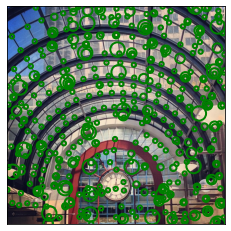

In [43]:
ImgBGR = cv2.imread('urban_edges.jpg')
imgGrey = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
Harris_Laplacian(ImgBGR,imgGrey,4,2,2.5,1.5,0.005,0.05)  #(Img_BGR,img_Grey,N,s0,p0,s,theta_corn,k)

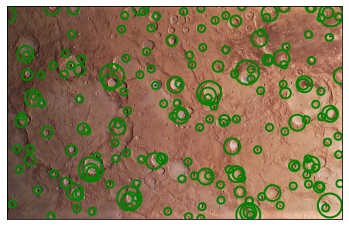

In [44]:
ImgBGR = cv2.imread('mars.png')
imgGrey = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
Harris_Laplacian(ImgBGR,imgGrey,4,2,2.5,1.5,0.005,0.05)  #(Img_BGR,img_Grey,N,s0,p0,s,theta_corn,k)

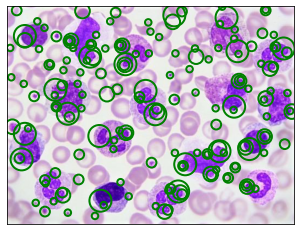

In [45]:
ImgBGR = cv2.imread('blood_smear.jpg')
imgGrey = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
Harris_Laplacian(ImgBGR,imgGrey,4,2,2.5,1.5,0.005,0.05)  #(Img_BGR,img_Grey,N,s0,p0,s,theta_corn,k)

## <center><b>2.3. Ανίχνευση Blobs <b/>  <center/>
## <b> 2.3.1 Υπολογισμός Μερικών Παραγώγων:

In [46]:
Img = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
Img = Img.astype(np.float)/255
sigma = 2
Theta_corn = 0.005
k=0.05

n = int(np.ceil(3*sigma)*2+1)
gaussian = cv2.getGaussianKernel(n,sigma) 
gauss2D = gaussian @ gaussian.T
Is= cv2.filter2D(Img, -1, gauss2D)

In [47]:
[Lx,Ly] = np.gradient(Is)
[Lxx,Lxy] = np.gradient(Lx)
[Lyx,Lyy] = np.gradient(Ly)
R = Lxx @ Lyy - Lxy @ Lxy

## <b> 2.3.2 Eπιλογή Σημείων Ενδιαφέροντος:

In [48]:
ns = np.ceil(3*sigma)*2+1                            
B_sq = disk_strel(ns)
Cond1 = ( R==cv2.dilate(R,B_sq) )
Cond2 = (R > Theta_corn*np.amax(R))
corners = (Cond1*Cond2).astype(np.uint8)

Συνάρτηση:

In [15]:
def blob_detect(Image,Img_BGR,sigma,Theta_corn,k): #Image is the grey one
    
    #Img = Image.astype(np.float)/255
    Img = Image.astype(np.float)/Image.max()
    
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    gauss2D = gaussian @ gaussian.T
    Is= cv2.filter2D(Img, -1, gauss2D)
    ######################################################
    
    [Lx,Ly] = np.gradient(Is)
    [Lxx,Lxy] = np.gradient(Lx)
    [Lyx,Lyy] = np.gradient(Ly)
    R = Lxx * Lyy - Lxy * Lxy
    ns = np.ceil(3*sigma)*2+1       
    
    ######################################################
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    Cond2 = (R > Theta_corn*np.amax(R))
    corners = (Cond1*Cond2).astype(np.uint8)
    
    ######################################################
    coords = np.nonzero(corners == 1)                  #find the coords of all elements==1
    kp_data = []
    for i in range(np.sum(corners)):
        kp_data.append([coords[1][i],coords[0][i],sigma])  #store them the way interest_points_visualization wants them

    img = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
    #temp = interest_points_visualization(img, kp_data)  #call only if you want to show points on image
    return corners

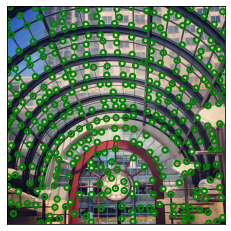

In [12]:
Img = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
Img_BGR = cv2.imread('urban_edges.jpg')
#Img = Img.astype(np.float)/255
x = blob_detect(Img,Img_BGR,2.5,0.005,0.05)

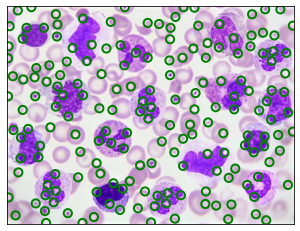

In [13]:
Img = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
Img_BGR = cv2.imread('blood_smear.jpg')
#Img = Img.astype(np.float)/255
x = blob_detect(Img,Img_BGR,2.5,0.005,0.05)

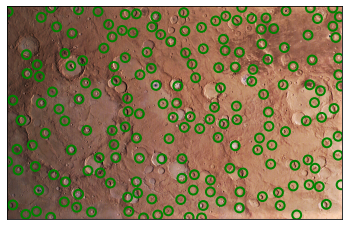

In [14]:
Img = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
Img_BGR = cv2.imread('mars.png')
#Img = Img.astype(np.float)/255
x = blob_detect(Img,Img_BGR,2.5,0.005,0.05)

## <center><b>2.4. Πολυκλιμακωτή Ανίχνευση Blobs<b/>  <center/>

In [16]:
def multi_blob_detect(Img_BGR,img_Grey,N,s0,s,theta_corn,k):
    sigma = []
    L = []
    coords = [] 
    kp_data2 = []
    I = img_Grey.astype(np.float)/img_Grey.max()
    corners = []
    #######################################################################################
    ###############################  Calculate all σ and ρ  ###############################
    ############ and run for each one the function from 2.1 "corner_detection" ############
    #######################################################################################
    
    for i in range(N):
        sigma.append(s**i*s0)                   
        corners.append(blob_detect(img_Grey,Img_BGR,sigma[i],theta_corn,k))
        
    #######################################################################################
    ###################################  Calculate LoG  ###################################
    #######################################################################################
    
        n = int(np.ceil(3*sigma[i])*2+1)
        gaussian = cv2.getGaussianKernel(n,sigma[i]) 
        gauss2D = gaussian @ gaussian.T
        LoG = cv2.Laplacian(gauss2D, cv2.CV_64F)
#         lin = np.linspace(-round(n/2),round(n/2),n)    
#         xx, yy = np.meshgrid(lin,lin)
#         LoG = (xx**2 + yy**2 -2*sigma[i]**2)*np.exp(-(xx**2 + yy**2)/(2*sigma[i]**2))/(2*np.pi*sigma[i]**6)
        L.append(sigma[i]**2*np.abs(cv2.filter2D(I, -1, LoG)))
        
    #######################################################################################
    # For each point we found calculate the value of the neighboring scales at that point #
    ######################  and find the max(previous,current,next  #######################
    ###################  Keep this point only if current is max value  ####################
    #######################################################################################
    for i in range(4):
        coords.append(np.nonzero(corners[i] == 1))
        #print(corners[i])
        for j in range(np.sum(corners[i])):
            current = L[i][coords[i][0][j]][coords[i][1][j]]
            
            if i == 0:
                previous = L[N-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[i+1][coords[i][0][j]][coords[i][1][j]]
                
            elif i == N-1:
                previous = L[i-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[0][coords[i][0][j]][coords[i][1][j]]
                
            else:
                previous = L[i-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[i+1][coords[i][0][j]][coords[i][1][j]]
                
            if (current > previous) & (current > Next):
                kp_data2.append([coords[i][1][j],coords[i][0][j],sigma[i]]) #1,0
                
                
    #print(kp_data2)
    img = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
    interest_points_visualization(img, kp_data2)

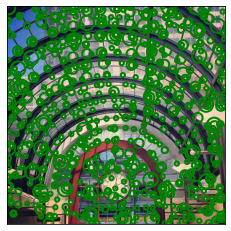

In [20]:
ImgBGR = cv2.imread('urban_edges.jpg')
imgGrey = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
#imgGrey = imgGrey.astype(np.float)/255
multi_blob_detect(ImgBGR,imgGrey,4,2,1.5,0.005,0.05)  #(Img_BGR,img_Grey,N,s0,s,theta_corn,k)

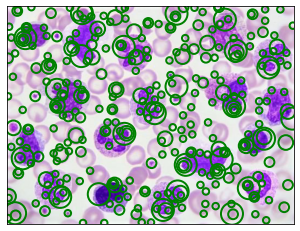

In [55]:
ImgBGR = cv2.imread('blood_smear.jpg')
imgGrey = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
#imgGrey = imgGrey.astype(np.float)/imgGrey.max()
#imgGrey = imgGrey.astype(np.float)/255
multi_blob_detect(ImgBGR,imgGrey,4,2,1.5,0.005,0.05)  #(Img_BGR,img_Grey,N,s0,s,theta_corn,k)

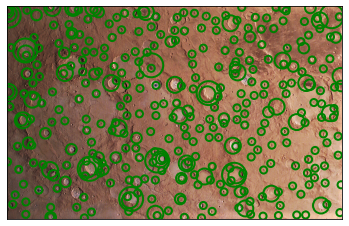

In [56]:
ImgBGR = cv2.imread('mars.png')
imgGrey = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
multi_blob_detect(ImgBGR,imgGrey,4,2,1.5,0.005,0.05)  #(Img_BGR,img_Grey,N,s0,s,theta_corn,k)

## <center><b>2.5. Επιτάχυνση με την χρήση Box Filters και Ολοκληρωτικών Εικόνων (Integral Images)<b/>  <center/>

In [22]:
def box_flt(Img_BGR,img_Grey,sigma,theta_corn):
    I = img_Grey.astype(np.float)/255  
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    gauss2D = gaussian @ gaussian.T
    I = cv2.filter2D(I, -1, gauss2D)
    
    S = np.cumsum(np.cumsum(I,axis=1),axis=0) 
    
    d1 = (4 * np.floor(n/6) + 1).astype(int) 
    d2 = (2 * np.floor(n/6) + 1).astype(int) 
    x = max(d1//2,3*d2//2)
    paddedS_xx = np.pad(S, ((x, x), (x, x))) #np.pad(arr , ((up,down),(left,right)))
    paddedS_yy = np.pad(S, ((x, x), (x, x)))
    paddedS_xy = np.pad(S, ((x, x), (x, x)))   

    Exx = paddedS_xx - np.roll(paddedS_xx,-d1+1,axis=0) - np.roll(paddedS_xx,-d2+1,axis=1) + np.roll(paddedS_xx,(-d1+1,-d2+1),axis=(0,1))
    Lxx = Exx + np.roll(Exx,-2*d2,axis=0) - 2*np.roll(Exx,-d2,axis=0)

    Eyy = paddedS_yy - np.roll(paddedS_yy,-d1+1,axis=1) - np.roll(paddedS_yy,-d2+1,axis=0) + np.roll(paddedS_yy,(-d1+1,-d2+1),axis=(1,0))
    Lyy = Eyy + np.roll(Eyy,-2*d2,axis=1) - 2*np.roll(Eyy,-d2,axis=1)

    Exy = paddedS_xy - np.roll(paddedS_xy,-d2+1,axis=1) - np.roll(paddedS_xy,-d2+1,axis=0) + np.roll(paddedS_xy,(-d2+1,-d2+1),axis=(0,1))
    Lxy = Exy - np.roll(Exy,-d2-1,axis=1) - np.roll(Exy,-d2-1,axis=0) + np.roll(Exy,(-d2-1,-d2-1),axis=(0,1))  
    
    
    R = Lxx*Lyy - 0.9*Lxy**2
    
    R = (R - R.min())/R.max() # turn to binary
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R == cv2.dilate(R,B_sq))
    Cond2 = (R > theta_corn*np.amax(R))

    corners = (Cond1&Cond2).astype(np.uint8)
    coords = np.nonzero(corners == 1)                  #find the coords of all elements==1
    kp_data = []

    for i in range(np.sum(corners)):
        kp_data.append([coords[1][i],coords[0][i],sigma])  #store them the way interest_points_visualization wants them

    img = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
    temp = interest_points_visualization(img, kp_data)  #call only if you want to show points on image
    return corners

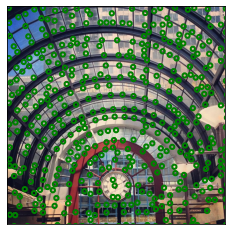

In [23]:
img = cv2.imread('urban_edges.jpg')
img_Grey = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
x = box_flt(img,img_Grey,2,0.005)

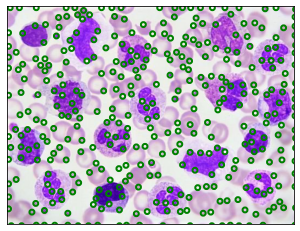

In [24]:
img = cv2.imread('blood_smear.jpg')
img_Grey = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
x = box_flt(img,img_Grey,1.5,0.005)

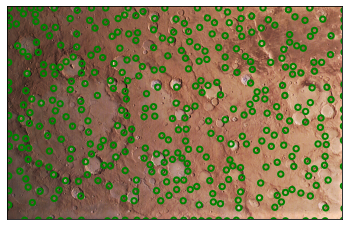

In [25]:
img = cv2.imread('mars.png')
img_Grey = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
x = box_flt(img,img_Grey,1.5,0.005)

In [61]:
def multi_box_flt(Img_BGR,img_Grey,N,s,s0,theta_corn):
    corners = []
    sigma = []
    L = []
    kp_data2 = []
    coords = [] 
    I = img_Grey.astype(np.float)/img_Grey.max()
    for i in range(N):
        sigma.append(s**i*s0)                   
        corners.append(box_flt(Img_BGR,img_Grey,sigma[i],theta_corn))
        
        #######################################################################################
        ###################################  Calculate LoG  ###################################
        #######################################################################################
        
        n = int(np.ceil(3*sigma[i])*2+1)
        gaussian = cv2.getGaussianKernel(n,sigma[i]) 
        gauss2D = gaussian @ gaussian.T
        LoG = cv2.Laplacian(gauss2D, cv2.CV_64F)
#         lin = np.linspace(-round(n/2),round(n/2),n)    
#         xx, yy = np.meshgrid(lin,lin)
#         LoG = (xx**2 + yy**2 -2*sigma[i]**2)*np.exp(-(xx**2 + yy**2)/(2*sigma[i]**2))/(2*np.pi*sigma[i]**6)
        L.append(sigma[i]**2*np.abs(cv2.filter2D(I, -1, LoG)))
        
        ######### keep max padding, to pad L, so that everything is the same size #############

        d1 = (4 * np.floor(n/6) + 1).astype(int) 
        d2 = (2 * np.floor(n/6) + 1).astype(int) 
        x = max(d1//2,3*d2//2)
        
        
        #######################################################################################
        ################################# Apply Same Condition ################################
        #######################################################################################
    for i in range(N):   
        L[i] = np.pad(L[i], ((x, x), (x, x)))
    for i in range(N):  
        coords.append(np.nonzero(corners[i] == 1))
        for j in range(np.sum(corners[i])):
            current = L[i][coords[i][0][j]][coords[i][1][j]]

            if i == 0:
                previous = L[N-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[i+1][coords[i][0][j]][coords[i][1][j]]

            elif i == N-1:
                previous = L[i-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[0][coords[i][0][j]][coords[i][1][j]]

            else:
                previous = L[i-1][coords[i][0][j]][coords[i][1][j]]
                Next =  L[i+1][coords[i][0][j]][coords[i][1][j]]

            if (current > previous) & (current > Next):
                kp_data2.append([coords[i][1][j],coords[i][0][j],sigma[i]])
                
                
    img = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
    interest_points_visualization(img, kp_data2)
    return kp_data2 #corners

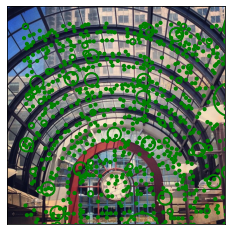

In [62]:
img = cv2.imread('urban_edges.jpg')
img_Grey = cv2.imread('urban_edges.jpg', cv2.IMREAD_GRAYSCALE)
x = multi_box_flt(img,img_Grey,4,2.5,1,0.005) #(Img_BGR,img_Grey,N,s,s0,theta_corn):

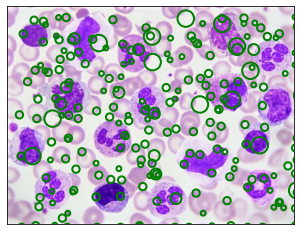

In [63]:
img = cv2.imread('blood_smear.jpg')
img_Grey = cv2.imread('blood_smear.jpg', cv2.IMREAD_GRAYSCALE)
x = multi_box_flt(img,img_Grey,4,1.5,1.5,0.005) #(Img_BGR,img_Grey,N,s,s0,theta_corn):

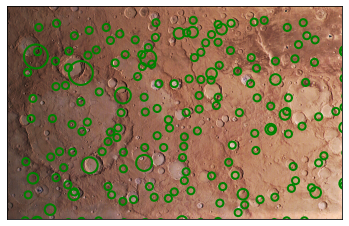

In [64]:
img = cv2.imread('mars.png')
img_Grey = cv2.imread('mars.png', cv2.IMREAD_GRAYSCALE)
x = multi_box_flt(img,img_Grey,4,1.5,2,0.005) #(Img_BGR,img_Grey,N,s,s0,theta_corn):

#  <center><b>Μέρος 3: Εφαρμογές σε Ταίριασμα και Κατηγοριοποίηση Εικόνων με Χρήση Τοπικών Περιγραφητών στα Σημεία Ενδιαφέροντος <b/>

## <center><b>3.1 Ταίριασμα Εικόνων υπό Περιστροφή και Αλλαγή Κλίμακας<b/>  <center/>

## <b> 3.1.2 

In [65]:
import cv21_lab1_part3_utils as p3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cv21_lab1_part2_utils import interest_points_visualization
from cv21_lab1_part2_utils import disk_strel
%matplotlib inline

corner_detection

In [66]:
def corner_detection(I, s=2, p0=2.5, k=0.05, theta_corn=0.005):
    p = p0
    sigma = s
    Image = I.astype(np.float)/255
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    Gs = gaussian @ gaussian.T
    Is = cv2.filter2D(Image, -1, Gs)
    
    ############################
    
    n = int(np.ceil(3*p)*2+1)
    gaussian = cv2.getGaussianKernel(n,p) 
    Gp = gaussian @ gaussian.T
    
    ############################
    
    [Ix,Iy]=np.gradient(Is)
    J1 = cv2.filter2D(Ix*Ix, -1, Gp)
    J2 = cv2.filter2D(Ix*Iy, -1, Gp)
    J3 = cv2.filter2D(Iy*Iy, -1, Gp)
    
    ############################
    
    lplus=(J1+J3+np.sqrt((J1-J3)**2+4*J2**2))/2
    lminus=(J1+J3-np.sqrt((J1-J3)**2+4*J2**2))/2
    
    ############################
    #R = np.matmul(lminus, lplus)-k*(lminus+lplus)**2
    #R = l_minus@l_plus - k * (l_minus + l_plus)**2
    R = lminus * lplus - k*(lminus + lplus)**2
    ns = np.ceil(3*sigma)*2+1                             
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    Cond2 = (R > theta_corn*np.amax(R))
    corners = (Cond1*Cond2).astype(np.uint8) # or &
    
    coords = np.nonzero(corners == 1)                  #find the coords of all elements==1
    kp_data = []
    for i in range(np.sum(corners)):
        kp_data.append([coords[1][i],coords[0][i],sigma])  #store them the way interest_points_visualization wants them
    return np.array(kp_data,dtype="object")

blob_detect

In [67]:
def blob_detect(I,sigma=2,k=0.05,Theta_corn=0.005): 
    
    Img = I.astype(np.float)/255
    
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    gauss2D = gaussian @ gaussian.T
    Is= cv2.filter2D(Img, -1, gauss2D)
    ######################################################
    
    [Lx,Ly] = np.gradient(Is)
    [Lxx,Lxy] = np.gradient(Lx)
    [Lyx,Lyy] = np.gradient(Ly)
    R = Lxx * Lyy - Lxy * Lxy
    ns = np.ceil(3*sigma)*2+1       
    
    ######################################################
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    Cond2 = (R > Theta_corn*np.amax(R))
    corners = (Cond1*Cond2).astype(np.uint8)
    
    ######################################################
    coords = np.nonzero(corners == 1)                  #find the coords of all elements==1
    kp_data = []
    for i in range(np.sum(corners)):
        kp_data.append([coords[1][i],coords[0][i],sigma])  #store them the way interest_points_visualization wants them


    return np.array(kp_data)

box_flt

In [68]:
def box_flt(I,sigma=2,theta_corn=0.005):
    Icopy = np.copy(I)
    Img = Icopy.astype(np.float)/255
    
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    gauss2D = gaussian @ gaussian.T
    Is = cv2.filter2D(Img, -1, gauss2D)
    
    S = np.cumsum(np.cumsum(Is,axis=1),axis=0)

    d1 = (4 * np.floor(n/6) + 1).astype(int) 
    d2 = (2 * np.floor(n/6) + 1).astype(int) 
    x = max(d1//2,3*d2//2)

    paddedS_xx = np.pad(S, ((x, x), (x, x))) #np.pad(arr , ((up,down),(left,right)))
    paddedS_yy = np.pad(S, ((x, x), (x, x)))
    paddedS_xy = np.pad(S, ((x, x), (x, x)))   
    I=np.pad(I,((x, x), (x, x)))
    
    Exx = paddedS_xx - np.roll(paddedS_xx,-d1+1,axis=0) - np.roll(paddedS_xx,-d2+1,axis=1) + np.roll(paddedS_xx,(-d1+1,-d2+1),axis=(0,1))
    Lxx = Exx + np.roll(Exx,-2*d2,axis=0) - 2*np.roll(Exx,-d2,axis=0)

    Eyy = paddedS_yy - np.roll(paddedS_yy,-d1+1,axis=1) - np.roll(paddedS_yy,-d2+1,axis=0) + np.roll(paddedS_yy,(-d1+1,-d2+1),axis=(1,0))
    Lyy = Eyy + np.roll(Eyy,-2*d2,axis=1) - 2*np.roll(Eyy,-d2,axis=1)

    Exy = paddedS_xy - np.roll(paddedS_xy,-d2+1,axis=1) - np.roll(paddedS_xy,-d2+1,axis=0) + np.roll(paddedS_xy,(-d2+1,-d2+1),axis=(0,1))
    Lxy = Exy - np.roll(Exy,-d2-1,axis=1) - np.roll(Exy,-d2-1,axis=0) + np.roll(Exy,(-d2-1,-d2-1),axis=(0,1))  
    
    
    R = Lxx*Lyy - 0.9*Lxy**2
    
    R = (R - R.min())/R.max() # turn to binary
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R == cv2.dilate(R,B_sq))
    Cond2 = (R > theta_corn*np.amax(R))

    corners = (Cond1*Cond2).astype(np.uint8)
    
    coords = np.nonzero(corners == 1)                  #find the coords of all elements==1
    kp_data = []

    for i in range(np.sum(corners)):
        if (coords[1][i] < I.shape[1]-x-1 and coords[1][i] > x-1 and coords[0][i] < I.shape[0]-x-1 and coords[0][i] > x-1):
            kp_data.append([coords[1][i],coords[0][i],sigma])  #store them the way interest_points_visualization wants them

    return np.array(kp_data)

Harris_laplacian

In [69]:
def Harris_Laplacian(I,N=4,s0=2,p0=2.5,s=2,k=0.05, theta_corn=0.005): #(ImgBGR,4,2,2.5,1.5,0.005,0.05) 
    #img_Grey = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2GRAY)
    sigma = []
    rho = []
    L = []
    coords = [] 
    kp_data2 = []
    corners = []
    img_Grey = I.astype(np.float)/255
    #######################################################################################
    ###############################  Calculate all σ and ρ  ###############################
    ############ and run for each one the function from 2.1 "corner_detection" ############
    #######################################################################################
    
    for i in range(N):
        sigma.append(s**i*s0)                   
        rho.append(s**i*p0)
        corners.append(corner_detection(I,sigma[i],rho[i],theta_corn,k))
        
    #######################################################################################
    ###################################  Calculate LoG  ###################################
    #######################################################################################
    
        n = int(np.ceil(3*sigma[i])*2+1)
        gaussian = cv2.getGaussianKernel(n,sigma[i]) 
        gauss2D = gaussian @ gaussian.T
        LoG = cv2.Laplacian(gauss2D, cv2.CV_64F)
#         lin = np.linspace(-round(n/2),round(n/2),n)    
#         xx, yy = np.meshgrid(lin,lin)
#         LoG = (xx**2 + yy**2 -2*sigma[i]**2)*np.exp(-(xx**2 + yy**2)/(2*sigma[i]**2))/(2*np.pi*sigma[i]**6)
        L.append(sigma[i]**2*np.abs(cv2.filter2D(img_Grey, -1, LoG)))
        
    ########################################################################################
    # For each point we found, calculate the value of the neighboring scales at that point #
    ######################  and find the max(previous,current,next)  #######################
    ###################  Keep this point only if current is max value  #####################
    ######################################################################################## 
    
    corners = np.array(corners,dtype="object")

    for i in range(4):
        for j in range(corners[i].shape[0]):
            current = L[i][int(corners[i][j][1])][int(corners[i][j][0])]
            
            if i == 0:
                previous = L[N-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[i+1][int(corners[i][j][1])][int(corners[i][j][0])]
                
            elif i == N-1:
                previous = L[i-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[0][int(corners[i][j][1])][int(corners[i][j][0])]
                
            else:
                previous = L[i-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[i+1][int(corners[i][j][1])][int(corners[i][j][0])]
                
            if (current > previous) & (current > Next):
                kp_data2.append([int(corners[i][j][0]),int(corners[i][j][1]),sigma[i]])
                
    return np.array(kp_data2)

multi_blob_detect

In [70]:
def multi_blob_detect(I,N=4,s0=2,s=2,k=0.05,theta_corn=0.005):
    sigma = []
    #multi_blob_detect    
    L = []
    coords = [] 
    kp_data2 = []
    corners = []
    img_Grey = I.astype(np.float)/255
    #######################################################################################
    ###############################  Calculate all σ and ρ  ###############################
    ############ and run for each one the function from 2.1 "corner_detection" ############
    #######################################################################################
    
    for i in range(N):
        sigma.append(s**i*s0)                   
        corners.append(blob_detect(I,sigma[i],theta_corn,k))
        
    #######################################################################################
    ###################################  Calculate LoG  ###################################
    #######################################################################################
    
        n = int(np.ceil(3*sigma[i])*2+1)
        gaussian = cv2.getGaussianKernel(n,sigma[i]) 
        gauss2D = gaussian @ gaussian.T
        LoG = cv2.Laplacian(gauss2D, cv2.CV_64F)
#         lin = np.linspace(-round(n/2),round(n/2),n)    
#         xx, yy = np.meshgrid(lin,lin)
#         LoG = (xx**2 + yy**2 -2*sigma[i]**2)*np.exp(-(xx**2 + yy**2)/(2*sigma[i]**2))/(2*np.pi*sigma[i]**6)
        L.append(sigma[i]**2*np.abs(cv2.filter2D(img_Grey, -1, LoG)))
        
    #######################################################################################
    # For each point we found calculate the value of the neighboring scales at that point #
    ######################  and find the max(previous,current,next  #######################
    ###################  Keep this point only if current is max value  ####################
    #######################################################################################
    
    corners = np.array(corners,dtype="object")
    
    for i in range(N):
        for j in range(corners[i].shape[0]):
            current = L[i][int(corners[i][j][1])][int(corners[i][j][0])]
            
            if i == 0:
                previous = L[N-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[i+1][int(corners[i][j][1])][int(corners[i][j][0])]
                
            elif i == N-1:
                previous = L[i-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[0][int(corners[i][j][1])][int(corners[i][j][0])]
                
            else:
                previous = L[i-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[i+1][int(corners[i][j][1])][int(corners[i][j][0])]
                
            if (current > previous) & (current > Next):
                kp_data2.append([int(corners[i][j][0]),int(corners[i][j][1]),sigma[i]])
                
    return np.array(kp_data2)

multi_box_flt

In [71]:
def multi_box_flt(I,N=4,s=2,s0=1,theta_corn=0.005): 
    corners = []
    sigma = []
    L = []
    kp_data2 = []
    coords = [] 
    for i in range(N):
        sigma.append(s**i*s0)                   
        corners.append(box_flt(I,sigma[i],theta_corn))
        #print(np.array(corners[i],dtype="object").shape)
        #######################################################################################
        ###################################  Calculate LoG  ###################################
        #######################################################################################
        
        n = int(np.ceil(3*sigma[i])*2+1)
        gaussian = cv2.getGaussianKernel(n,sigma[i]) 
        gauss2D = gaussian @ gaussian.T
        LoG = cv2.Laplacian(gauss2D, cv2.CV_64F)
#         lin = np.linspace(-round(n/2),round(n/2),n)    
#         xx, yy = np.meshgrid(lin,lin)
#         LoG = (xx**2 + yy**2 -2*sigma[i]**2)*np.exp(-(xx**2 + yy**2)/(2*sigma[i]**2))/(2*np.pi*sigma[i]**6)
        L.append(sigma[i]**2*np.abs(cv2.filter2D(I, -1, LoG)))
        
        ######### keep max padding, to pad L, so that everything is the same size #############

        d1 = (4 * np.floor(n/6) + 1).astype(int) 
        d2 = (2 * np.floor(n/6) + 1).astype(int) 
        x = max(d1//2,3*d2//2)
        
        
        #######################################################################################
        ################################# Apply Same Condition ################################
        #######################################################################################
    for i in range(N):   
        L[i] = np.pad(L[i], ((x, x), (x, x)))
        
    corners = np.array(corners,dtype="object")
    
    for i in range(N):
        for j in range(corners[i].shape[0]):
            current = L[i][int(corners[i][j][1])][int(corners[i][j][0])]
            
            if i == 0:
                previous = L[N-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[i+1][int(corners[i][j][1])][int(corners[i][j][0])]
                
            elif i == N-1:
                previous = L[i-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[0][int(corners[i][j][1])][int(corners[i][j][0])]
                
            else:
                previous = L[i-1][int(corners[i][j][1])][int(corners[i][j][0])]
                Next =  L[i+1][int(corners[i][j][1])][int(corners[i][j][0])]
                
            if (current > previous) & (current > Next):
                kp_data2.append([int(corners[i][j][0]),int(corners[i][j][1]),sigma[i]])
                
    return np.array(kp_data2)

In [72]:
def matching_evaluation_SURF(function):
    detect_fun = lambda I: function(I) 
    desc_fun = lambda I, kp: p3.featuresSURF(I,kp)
    avg_scale_errors, avg_theta_errors = p3.matching_evaluation(detect_fun, desc_fun)
    for i in range(3): 
        print('Avg. Scale Error for Image ',i+1,': {:.3f}'.format(avg_scale_errors[i]))
        print('Avg. Theta Error for Image ',i+1,': {:.3f}'.format(avg_theta_errors[i]))    
    
def matching_evaluation_HOG(function):
    detect_fun = lambda I: function(I) 
    desc_fun = lambda I, kp: p3.featuresHOG(I,kp)
    avg_scale_errors, avg_theta_errors = p3.matching_evaluation(detect_fun, desc_fun)
    
    for i in range(3):
        print('Avg. Scale Error for Image ',i+1,': {:.3f}'.format(avg_scale_errors[i]))
        print('Avg. Theta Error for Image ',i+1,': {:.3f}'.format(avg_theta_errors[i]))    

In [73]:
matching_evaluation_SURF(corner_detection)
matching_evaluation_HOG(corner_detection)

Avg. Scale Error for Image  1 : 0.003
Avg. Theta Error for Image  1 : 1.968
Avg. Scale Error for Image  2 : 0.002
Avg. Theta Error for Image  2 : 0.318
Avg. Scale Error for Image  3 : 0.097
Avg. Theta Error for Image  3 : 12.909
Avg. Scale Error for Image  1 : 0.186
Avg. Theta Error for Image  1 : 22.619
Avg. Scale Error for Image  2 : 0.351
Avg. Theta Error for Image  2 : 19.199
Avg. Scale Error for Image  3 : 0.285
Avg. Theta Error for Image  3 : 23.699


In [74]:
matching_evaluation_SURF(Harris_Laplacian)
matching_evaluation_HOG(Harris_Laplacian)

Avg. Scale Error for Image  1 : 0.002
Avg. Theta Error for Image  1 : 0.156
Avg. Scale Error for Image  2 : 0.005
Avg. Theta Error for Image  2 : 0.313
Avg. Scale Error for Image  3 : 0.004
Avg. Theta Error for Image  3 : 0.319
Avg. Scale Error for Image  1 : 0.131
Avg. Theta Error for Image  1 : 15.515
Avg. Scale Error for Image  2 : 1.045
Avg. Theta Error for Image  2 : 37.957
Avg. Scale Error for Image  3 : 0.253
Avg. Theta Error for Image  3 : 22.740


In [75]:
matching_evaluation_SURF(blob_detect)
matching_evaluation_HOG(blob_detect)

Avg. Scale Error for Image  1 : 0.027
Avg. Theta Error for Image  1 : 7.759
Avg. Scale Error for Image  2 : 0.010
Avg. Theta Error for Image  2 : 0.229
Avg. Scale Error for Image  3 : 0.001
Avg. Theta Error for Image  3 : 0.054
Avg. Scale Error for Image  1 : 0.186
Avg. Theta Error for Image  1 : 7.231
Avg. Scale Error for Image  2 : 0.100
Avg. Theta Error for Image  2 : 13.674
Avg. Scale Error for Image  3 : 0.154
Avg. Theta Error for Image  3 : 27.219


In [76]:
matching_evaluation_SURF(multi_blob_detect)
matching_evaluation_HOG(multi_blob_detect)

Avg. Scale Error for Image  1 : 0.002
Avg. Theta Error for Image  1 : 0.120
Avg. Scale Error for Image  2 : 0.003
Avg. Theta Error for Image  2 : 0.152
Avg. Scale Error for Image  3 : 0.002
Avg. Theta Error for Image  3 : 0.137
Avg. Scale Error for Image  1 : 0.212
Avg. Theta Error for Image  1 : 18.952
Avg. Scale Error for Image  2 : 0.241
Avg. Theta Error for Image  2 : 19.897
Avg. Scale Error for Image  3 : 0.255
Avg. Theta Error for Image  3 : 23.719


In [77]:
matching_evaluation_SURF(multi_box_flt)
matching_evaluation_HOG(multi_box_flt)

Avg. Scale Error for Image  1 : 0.051
Avg. Theta Error for Image  1 : 2.701
Avg. Scale Error for Image  2 : 0.023
Avg. Theta Error for Image  2 : 3.612
Avg. Scale Error for Image  3 : 0.043
Avg. Theta Error for Image  3 : 11.951
Avg. Scale Error for Image  1 : 0.142
Avg. Theta Error for Image  1 : 20.306
Avg. Scale Error for Image  2 : 0.332
Avg. Theta Error for Image  2 : 31.674
Avg. Scale Error for Image  3 : 0.202
Avg. Theta Error for Image  3 : 26.599


## <center><b>3.2 Κατηγοριοποίηση Εικόνων<b/>  <center/>

In [78]:
def classification_SURF(func):
    detect_fun = lambda I: func(I)

    desc_fun = lambda I, kp: p3.featuresSURF(I,kp)

        # Extract features from the provided dataset.
    feats = p3.FeatureExtraction(detect_fun, desc_fun)

        # If the above code takes too long, you can use the following extra parameters of Feature extraction:
        #   saveFile = <filename>: Save the extracted features in a file with the provided name.
        #   loadFile = <filename>: Load the extracted features from a given file (which MUST exist beforehand).

    accs = []
    for k in range(5):
            # Split into a training set and a test set.
        data_train, label_train, data_test, label_test = p3.createTrainTest(feats, k)

            # Perform Kmeans to find centroids for clusters.
        BOF_tr, BOF_ts = p3.BagOfWords(data_train, data_test)

            # Train an svm on the training set and make predictions on the test set
        acc, preds, probas = p3.svm(BOF_tr, label_train, BOF_ts, label_test)
        accs.append(acc)

    print('Mean accuracy for' ,func.__name__, 'with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

def classification_HOG(func):
    detect_fun = lambda I: func(I)

    desc_fun = lambda I, kp: p3.featuresHOG(I,kp)

        # Extract features from the provided dataset.
    feats = p3.FeatureExtraction(detect_fun, desc_fun)

        # If the above code takes too long, you can use the following extra parameters of Feature extraction:
        #   saveFile = <filename>: Save the extracted features in a file with the provided name.
        #   loadFile = <filename>: Load the extracted features from a given file (which MUST exist beforehand).

    accs = []
    for k in range(5):
            # Split into a training set and a test set.
        data_train, label_train, data_test, label_test = p3.createTrainTest(feats, k)

            # Perform Kmeans to find centroids for clusters.
        BOF_tr, BOF_ts = p3.BagOfWords(data_train, data_test)

            # Train an svm on the training set and make predictions on the test set
        acc, preds, probas = p3.svm(BOF_tr, label_train, BOF_ts, label_test)
        accs.append(acc)

    print('Mean accuracy for' ,func.__name__, 'with HOG descriptors: {:.3f}%'.format(100.0*np.mean(accs)))


In [79]:
classification_SURF(Harris_Laplacian)

Time for feature extraction: 701.501


C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarni

Mean accuracy for Harris_Laplacian with SURF descriptors: 60.414%


In [80]:
classification_SURF(multi_blob_detect)

Time for feature extraction: 668.206


C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarni

Mean accuracy for multi_blob_detect with SURF descriptors: 56.138%


In [81]:
classification_SURF(multi_box_flt)

Time for feature extraction: 261.861


C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarni

Mean accuracy for multi_box_flt with SURF descriptors: 61.931%


In [82]:
classification_HOG(Harris_Laplacian)

Time for feature extraction: 711.096


C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarni

Mean accuracy for Harris_Laplacian with HOG descriptors: 66.483%


In [83]:
classification_HOG(multi_blob_detect)

Time for feature extraction: 678.292


C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarni

Mean accuracy for multi_blob_detect with HOG descriptors: 68.966%


In [84]:
classification_HOG(multi_box_flt)

Time for feature extraction: 300.236


C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Anaconda\envs\cv_lab1_env\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarni

Mean accuracy for multi_box_flt with HOG descriptors: 68.138%
